<a href="https://colab.research.google.com/github/Kompactss/my_codes/blob/main/Electra_QA(%EA%B3%A0%EA%B4%91%EC%97%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Download and Load

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install bertviz
!pip install plotly
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 77.7 MB/s 
     |████████████████████████████████| 6.6 MB 53.9 MB/s 
     |████████████████████████████████| 101 kB 4.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 4.0 MB/s 
     |████████████████████████████████| 419 kB 82.2 MB/s 
     |████████████████████████████████| 140 kB 73.0 MB/s 
     |████████████████████████████████| 1.1 MB 55.3 MB/s 
     |████████████████████████████████| 144 kB 57.0 MB/s 
     |████████████████████████████████| 271 kB 60.5 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
Looking in indexes: 

In [ ]:
!pip install wandb

In [ ]:
!wandb login

wandb: Currently logged in as: kompactss (use `wandb login --relogin` to force relogin)


In [ ]:

import json
import pandas as pd
import numpy as np
import torch
torch.cuda.empty_cache()
from pathlib import Path # 파일시스템의 경로를 단순한 문자열이 아닌 객체로 다루게 하는 것
from torch.utils.data import Dataset, DataLoader, SequentialSampler

from sklearn.model_selection import train_test_split
from termcolor import colored
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim



from transformers import (
    AdamW,
    RobertaForSequenceClassification,
    RobertaModel,
    RobertaTokenizer,
    RobertaForQuestionAnswering,
    AutoModel,
    AutoTokenizer,
    BertTokenizerFast, AlbertModel,
    AlbertTokenizer,
    AutoModelForQuestionAnswering
)
from tqdm.auto import tqdm
from bertviz import head_view

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import gc


import warnings

warnings.filterwarnings(action='ignore') 
from plotly import graph_objs as go

from collections import Counter
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os

DIR = "/content/gdrive/MyDrive/k-digital-goorm-3-korean-mrc/"
TRAIN_SOURCE = os.path.join(DIR, "train.json")
TEST_SOURCE = os.path.join(DIR, "test.json")

with open(TRAIN_SOURCE) as f:
    TRAIN_DATA = json.loads(f.read())

with open(TEST_SOURCE) as f:
    TEST_DATA = json.loads(f.read())

In [ ]:
train = pd.DataFrame(columns=['guid' ,'title' ,'news_category', 'context', 'question' ,'answer_start', 'text'])
guid = 0
for data in TRAIN_DATA['data']:
    for paragraphs in data['paragraphs']:
        for line in paragraphs['qas']:
            train.loc[guid, 'context'] = paragraphs['context']
            train.loc[guid, 'question'] = line['question']
            train.loc[guid, 'answer_start'] = line['answers'][0]['answer_start']
            train.loc[guid, 'text'] = line['answers'][0]['text']            
            train.loc[guid, 'title'] = data['title']
            train.loc[guid, 'guid'] = line['guid']
            train.loc[guid, 'news_category'] = data['news_category']
            guid += 1

In [ ]:
test = pd.DataFrame(columns=['guid','title' ,'news_category', 'context', 'question' ])
guid = 0
for data in TEST_DATA['data']:
    for paragraphs in data['paragraphs']:
        for line in paragraphs['qas']:
            test.loc[guid, 'context'] = paragraphs['context']
            test.loc[guid, 'question'] = line['question']
            test.loc[guid, 'title'] = data['title']
            test.loc[guid, 'guid'] = line['guid']
            test.loc[guid, 'news_category'] = data['news_category']
            guid += 1

In [ ]:
train_ai_hub = pd.read_csv('/content/gdrive/MyDrive/k-digital-goorm-3-korean-mrc/ai_hub_data.csv')

In [ ]:
len(train)

12037

In [ ]:
train = train.drop('news_category', axis=1)
train = pd.concat([train, train_ai_hub]).reset_index().drop('index', axis=1)
train = train.reset_index().drop('index', axis=1)

In [ ]:
train = train[:30000]  # v1(mine) 
#train = train[:50000]    # v2

In [ ]:
def get_answers(x):
    start = x[0]
    text = x[1]
    return {
        'answer_start': [start],
        'text': [text]
    }


train['answers'] = train[['answer_start', 'text']].apply(get_answers, axis=1)

In [ ]:
train_df, val_df = train_test_split(train, test_size=0.1, random_state=42)

train_df = train_df.reset_index().drop('index', axis=1)
val_df = val_df.reset_index().drop('index', axis=1)

train_df.shape, val_df.shape

((27000, 7), (3000, 7))

In [ ]:
max_length = 512

In [ ]:
MODEL_NAME = 'monologg/koelectra-base-v3-finetuned-korquad'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/111 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/591 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/257k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
train_df[:10]['answers']

0             {'answer_start': [185], 'text': ['12개']}
1    {'answer_start': [838], 'text': ['정부의 미세먼지 개선 ...
2              {'answer_start': [340], 'text': ['18']}
3    {'answer_start': [125], 'text': ['서울시청, 세빛섬, 국...
4            {'answer_start': [23], 'text': ['2010년']}
5    {'answer_start': [276], 'text': ['같은 내용의 책이라면 ...
6     {'answer_start': [0], 'text': ['16일 오후 2시50분께']}
7    {'answer_start': [278], 'text': ['‘변혁의 새시대를 열어...
8    {'answer_start': [99], 'text': ['오후 들어 낙폭이 커지면...
9          {'answer_start': [226], 'text': ['‘착한기변’']}
Name: answers, dtype: object

In [ ]:
def prepare_train_features(example, tokenizer):
    example["question"] = example["question"].lstrip()
    tokenized_example = tokenizer(
        example["question"],
        example["context"],
        truncation="only_second",
        max_length=max_length,
        stride=50, 
        return_overflowing_tokens=True, # 길이를 넘어가는 토큰들을 반환할 것인지
        return_offsets_mapping=True,  # 각 토큰에 대해 (char_start, char_end) 정보를 반환한 것인지
        padding="max_length",
    )

    sample_mapping = tokenized_example.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_example.pop("offset_mapping")

    features = []
    for i, offsets in enumerate(offset_mapping):
        feature = {}

        input_ids = tokenized_example["input_ids"][i]
        attention_mask = tokenized_example["attention_mask"][i]

        feature['input_ids'] = input_ids
        feature['attention_mask'] = attention_mask
        feature['offset_mapping'] = offsets

        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = tokenized_example.sequence_ids(i)

        sample_index = sample_mapping[i]
        answers = example["answers"]

        if len(answers["answer_start"]) == 0:
            feature["start_position"] = cls_index
            feature["end_position"] = cls_index
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                feature["start_position"] = cls_index
                feature["end_position"] = cls_index
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                feature["start_position"] = token_start_index - 1
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                feature["end_position"] = token_end_index + 1

        features.append(feature)
    return features

In [ ]:
train_features, valid_features = [[] for _ in range(2)]
for i, row in tqdm(train_df.iterrows()):
    train_features += prepare_train_features(row, tokenizer)
for i, row in tqdm(val_df.iterrows()):
    valid_features += prepare_train_features(row, tokenizer)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
class DatasetRetriever(Dataset):
    def __init__(self, features, mode='train'):
        super(DatasetRetriever, self).__init__()
        self.features = features
        self.mode = mode
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, item):   
        feature = self.features[item]
        if self.mode == 'train':
            return {
                'input_ids':torch.tensor(feature['input_ids'] ,dtype=torch.long),
                'attention_mask':torch.tensor(feature['attention_mask'], dtype=torch.long),
                'offset_mapping':torch.tensor(feature['offset_mapping'], dtype=torch.long),
                'start_position':torch.tensor(feature['start_position'], dtype=torch.long),
                'end_position':torch.tensor(feature['end_position'], dtype=torch.long)
            }
        else:
            return {
                'input_ids':torch.tensor(feature['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(feature['attention_mask'], dtype=torch.long),
                'offset_mapping':feature['offset_mapping'],
                'sequence_ids':feature['sequence_ids'],
                'id':feature['example_id'],
                'context': feature['context'],
                'question': feature['question']
            }

In [ ]:
train_dataset = DatasetRetriever(train_features)
valid_dataset = DatasetRetriever(valid_features)

In [ ]:
len(train_dataset), len(valid_dataset)

(39472, 4352)

In [ ]:
for data in train_dataset:
  print("Input ids: ", data['input_ids'])
  if data['start_position'] != 0 and data['end_position'] != 0:  
    print("start_positions: ", data['start_position'])
    print("end_positions: ", data['end_position'])
    break

Input ids:  tensor([    2,  8432, 14246, 11874,  4073,  4034,  2676,  2027,  3675,  4007,
         7213,  4398,  4065,    35,     3,  7970,  5014,  4112,  3158,  4034,
         6242,  4501,    29,  4366,  6406,  6307,  4366,  4149,  4200,    23,
         4366,  4629,   144,  8651,  4114,  9886, 27040,   145,  3238,    25,
         4020,  4205, 27040,  4068,  4139,   144,  8432, 14246,    22,   145,
         3238, 13712,  4292,  7491, 10749,  6355,  7796,  4219,  6308,  4176,
           18,  6232,    25,  4501,    21,  4366,  6406,    28,  4501,  6759,
         4366,  4149,  4200,    24,  4217,  4501,  4629,  6355,  4880, 30054,
        33334,  4073,  4129,  3467,  7963,  4217,  3675,  4007,  6679,  4199,
         4139,  7196,  4192,  6261,  6557,  4234, 18040,  4292,  6459,  5365,
         6460,    16,  9111,    21,    16,    22,    16,    23,  6928, 11063,
         4073,  4129,  7296,  4283,  6300,  4217,  3675,  4007,    29,  4501,
         4073, 11874, 18050,  6297,  4110, 10248,  4

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoPreTrainedModel,AutoModel

class AutoModelForQuestionAnswering(AutoPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.arch = AutoModel(config, add_pooling_layer=False)
        self.start_linear = nn.Linear(config.hidden_size, 1)
        self.end_linear = nn.Linear(config.hidden_size, 1)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        start_logits = self.start_linear(outputs.last_hidden_state).squeeze(-1)
        end_logits = self.end_linear(outputs.last_hidden_state).squeeze(-1)

        return start_logits, end_logits

In [ ]:
import wandb
wandb.init(project="Gwang-Yeon(MRC)", 
           entity="goorm-team3",
           config = {
        "learning_rate": 2e-5,
        "epochs": 10,
        "batch_size": 256,
        "accumulation": 32,
        "seed": 42
})
config = wandb.config

wandb: Currently logged in as: kompactss (use `wandb login --relogin` to force relogin)


In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/429M [00:00<?, ?B/s]

In [ ]:
model

ElectraForQuestionAnswering(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768

In [ ]:
import os
from statistics import mean

import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from transformers import AutoModelForQuestionAnswering
from transformers import default_data_collator

batch_size = config.batch_size
accumulation = config.accumulation
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
model.cuda()
data_collator = default_data_collator

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size//accumulation, 
    shuffle=True,
    collate_fn=data_collator,
    num_workers=2)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size//accumulation, 
    shuffle=False, 
    collate_fn=data_collator, 
    num_workers=2)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

os.makedirs('dump', exist_ok=True)
train_losses = []
dev_losses = []

step = 0

for epoch in range(1, config.epochs+1):
    print("Epoch", epoch)
    # Training
    running_loss = 0.
    losses = []
    model.train()
    progress_bar = tqdm(train_loader, desc='Train')
    for batch in progress_bar:
        del batch['offset_mapping']
        optimizer.zero_grad(set_to_none=True)
        batch = {key: value.cuda() for key, value in batch.items()}
        start = batch.pop('start_position')
        end = batch.pop('end_position')
        
        output = model(**batch)
        start_logits = output.start_logits
        end_logits = output.end_logits
        loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)
        (loss / accumulation).backward()
        running_loss += loss.item()
        del batch, start, end, start_logits, end_logits, loss
        
        step += 1
        if step % accumulation:
            continue

        clip_grad_norm_(model.parameters(), max_norm=1.)
        optimizer.step()

        losses.append(running_loss / accumulation)
        running_loss = 0.
        progress_bar.set_description(f"Train - Loss: {losses[-1]:.3f}")
        wandb.log({"train loss": losses[-1]})
    train_losses.append(mean(losses))
    print(f"train score: {train_losses[-1]:.3f}")
    wandb.log({"train score": train_losses[-1]})

    # Evaluation
    losses = []
    model.eval()
    for batch in tqdm(valid_loader, desc="Evaluation"):
        del batch['offset_mapping']
        batch = {key: value.cuda() for key, value in batch.items()}
        start = batch.pop('start_position')
        end = batch.pop('end_position')
        
        with torch.no_grad():
            output = model(**batch)
            start_logits = output.start_logits
            end_logits = output.end_logits
        loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)

        losses.append(loss.item())
        wandb.log({"valid loss": losses[-1]})
        del batch, start, end, start_logits, end_logits, loss
    dev_losses.append(mean(losses))
    print(f"Evaluation score: {dev_losses[-1]:.3f}")
    wandb.log({"valid score": dev_losses[-1]})

    model.save_pretrained(f'/content/gdrive/MyDrive/k-digital-goorm-3-korean-mrc/dump/model(koelectra).{epoch}')

Epoch 1


Train:   0%|          | 0/4934 [00:00<?, ?it/s]

train score: 4.626


Evaluation:   0%|          | 0/544 [00:00<?, ?it/s]

Evaluation score: 3.304
Epoch 2


Train:   0%|          | 0/4934 [00:00<?, ?it/s]

train score: 3.280


Evaluation:   0%|          | 0/544 [00:00<?, ?it/s]

Evaluation score: 3.019
Epoch 3


Train:   0%|          | 0/4934 [00:00<?, ?it/s]

train score: 3.066


Evaluation:   0%|          | 0/544 [00:00<?, ?it/s]

Evaluation score: 2.956


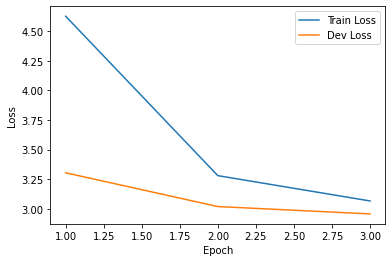

In [ ]:
import matplotlib.pyplot as plt

t = list(range(1, 4))
plt.plot(t, train_losses, label="Train Loss")
plt.plot(t, dev_losses, label="Dev Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Inference

In [ ]:
def prepare_test_features(example, tokenizer):
    example["question"] = example["question"].lstrip()
    
    tokenized_example = tokenizer(
        example["question"],
        example["context"],
        truncation="only_second",
        max_length=512,
        stride=50,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    features = []
    for i in range(len(tokenized_example["input_ids"])):
        feature = {}
        feature["example_id"] = example['guid']
        feature['context'] = example['context']
        feature['question'] = example['question']
        feature['input_ids'] = tokenized_example['input_ids'][i]
        feature['attention_mask'] = tokenized_example['attention_mask'][i]
        feature['offset_mapping'] = tokenized_example['offset_mapping'][i]
        feature['sequence_ids'] = [0 if i is None else i for i in tokenized_example.sequence_ids(i)]
        features.append(feature)
    return features

In [ ]:
import collections

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 20):
    all_start_logits, all_end_logits = raw_predictions
    
    example_id_to_index = {k: i for i, k in enumerate(examples["guid"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    predictions = collections.OrderedDict()

    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    for example_index, example in examples.iterrows():
        feature_indices = features_per_example[example_index]

        min_null_score = None
        valid_answers = []
        
        context = example["context"]
        for feature_index in feature_indices:
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]

            sequence_ids = features[feature_index]["sequence_ids"]
            context_index = 1

            features[feature_index]["offset_mapping"] = [
                (o if sequence_ids[k] == context_index else None)
                for k, o in enumerate(features[feature_index]["offset_mapping"])
            ]
            offset_mapping = features[feature_index]["offset_mapping"]
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            best_answer = {"text": "", "score": 0.0}
        
        predictions[example["guid"]] = best_answer["text"]
        
        
    return predictions

In [ ]:
test_features = []
for i, row in test.iterrows():
    test_features += prepare_test_features(row, tokenizer)

In [ ]:
test_dataset = DatasetRetriever(test_features, mode='test')
test_dataloader = DataLoader(
    test_dataset,
    batch_size=8, 
    shuffle=False,
    num_workers=2,
    pin_memory=True, 
    drop_last=False
)

In [ ]:
def get_predictions(trained_model):
    model = trained_model.cuda()
    
    start_logits = []
    end_logits = []
    model.eval()
    for batch in tqdm(test_dataloader):
        with torch.no_grad():
            output = model(batch['input_ids'].cuda(), batch['attention_mask'].cuda())
            start_logits.append(output.start_logits.cpu().numpy().tolist())
            end_logits.append(output.end_logits.cpu().numpy().tolist())
            del output
    gc.collect()
    return np.vstack(start_logits), np.vstack(end_logits)

In [ ]:
start_logits, end_logits = get_predictions(trained_model=model)
# Now Calling Function 

fin_preds = postprocess_qa_predictions(test, test_features, (start_logits, end_logits))

  0%|          | 0/772 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3faa774a70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3faa774a70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Post-processing 4008 example predictions split into 6169 features.


In [ ]:
from string import punctuation
submission = []
for p1, p2 in fin_preds.items():
    p2 = " ".join(p2.split())
    p2 = p2.strip(punctuation)
    submission.append((p1, p2))
    
sample = pd.DataFrame(submission, columns=["id", "Predicted"])

#test_data =pd.merge(left=test_df,right=sample,on='id')

In [ ]:
sample.to_csv('/content/gdrive/MyDrive/k-digital-goorm-3-korean-mrc/out/koelectra_v1.csv', index=False)
sample = sample.rename({'id':'guid'}, axis='columns')

test_data =pd.merge(left=test,right=sample,on='guid')

In [ ]:
test_data

,guid,title,news_category,context,question,Predicted
0,d14cb73158624cf094c546d856fd3c80,"BMW 코리아, 창립 25주년 기념 ‘BMW 코리아 25주년 에디션’ 한정 출시",자동차,BMW 코리아(대표 한상윤)는 창립 25주년을 기념하는 ‘BMW 코리아 25주년 에...,말라카이트에서 나온 색깔을 사용한 에디션은?,뉴 740Li 25주년 에디션
1,906631384e91493ebe1c7f34aea6f241,"佛 검찰 “독일 여객기, 부조종사가 의도적으로 추락”",국제,프랑스 남부 알프스에 떨어져 150명의 사망자를 낸 저먼윙스 여객기는 부조종사가 의...,사고 비행기의 목적지는?,독일 뒤셀도르프로
2,35e61dcb479643448a2cb7d326ae50a6,"도전적인 일, 리더에 대한 신뢰, 협력 문화 …...가고 싶다, 이 회사 … 베인&...",국제,가장 일하고 싶은 회사로 미국 컨설팅 업체인 베인&컴퍼니가 선정됐다. 트위터와 링크...,2014년 일하고 싶은 50대 회사 중에서 5위로 선정된 기업은?,링크트인과 페이스북
3,075e761b370040cb9041eecd39afc27c,"도전적인 일, 리더에 대한 신뢰, 협력 문화 …...가고 싶다, 이 회사 … 베인&...",국제,가장 일하고 싶은 회사로 미국 컨설팅 업체인 베인&컴퍼니가 선정됐다. 트위터와 링크...,포브스의 2014년 일하고 싶은 50대 회사 조사에서 5위를 한 기업은?,링크트인과 페이스북
4,e67ed38f3dd944be94d5b4c53731f334,호세 카레라스,None,성악가로서 한창 전성기를 구가하던 1987년 호세 카레라스는 청천벽력같은 소식을 듣...,호세 카레라스가 재단의 도움을 받아 병을 치료한 병원의 소재지는?,마드리드
...,...,...,...,...,...,...
4003,05fcb8054dc44dab8683579c2cf5e465,"企銀, 전 해외지점장 대출한도 축소",금융,일본 도쿄지점 130억원대 부당대출 혐의로 금융감독원의 검사를 받고 있는 기업은행이...,도쿄지점의 현재 개인 신용대출 한도는?,400만엔
4004,cc7f826b66724ce9b39e3a974ca15661,그해 겨울은 따뜻했네,None,한국전쟁 당시 언니인 수지는 여동생 오목이를 고의로 방치했다. 수지는 신경쓰지 않고...,오목이 수지에게 청탁한 남편의 일자리 장소는?,중동 건설 현장
4005,3282034aa41e4fab980851ffd4a868dd,‘안개’에 파묻힌 해운업계 … 공급 과잉에 컨船 운임 사상최저,산업섹션,세계 컨테이너선 운임지수가 사상 최저 수준으로 떨어지면서 해운업계에 비상이 걸렸다....,컨테이너선 평균 운임이 15%정도 낮아진 노선은?,아시아~유럽 노선
4006,0a73550b36df4baf82ac2f98619d22e7,강남·서초 유치원·초교 8~10일 전면휴업,사회,"서울교육청이 8일부터 10일까지 강남구, 서초구 지역에 있는 유치원, 초등학교의 전...",강남지역에 사는 학생들은 며칠 동안 학교를 안가나?,사흘


In [ ]:
test_data.head(15)

,guid,title,news_category,context,question,Predicted
0,d14cb73158624cf094c546d856fd3c80,"BMW 코리아, 창립 25주년 기념 ‘BMW 코리아 25주년 에디션’ 한정 출시",자동차,BMW 코리아(대표 한상윤)는 창립 25주년을 기념하는 ‘BMW 코리아 25주년 에...,말라카이트에서 나온 색깔을 사용한 에디션은?,뉴 740Li 25주년 에디션
1,906631384e91493ebe1c7f34aea6f241,"佛 검찰 “독일 여객기, 부조종사가 의도적으로 추락”",국제,프랑스 남부 알프스에 떨어져 150명의 사망자를 낸 저먼윙스 여객기는 부조종사가 의...,사고 비행기의 목적지는?,독일 뒤셀도르프로
2,35e61dcb479643448a2cb7d326ae50a6,"도전적인 일, 리더에 대한 신뢰, 협력 문화 …...가고 싶다, 이 회사 … 베인&...",국제,가장 일하고 싶은 회사로 미국 컨설팅 업체인 베인&컴퍼니가 선정됐다. 트위터와 링크...,2014년 일하고 싶은 50대 회사 중에서 5위로 선정된 기업은?,링크트인과 페이스북
3,075e761b370040cb9041eecd39afc27c,"도전적인 일, 리더에 대한 신뢰, 협력 문화 …...가고 싶다, 이 회사 … 베인&...",국제,가장 일하고 싶은 회사로 미국 컨설팅 업체인 베인&컴퍼니가 선정됐다. 트위터와 링크...,포브스의 2014년 일하고 싶은 50대 회사 조사에서 5위를 한 기업은?,링크트인과 페이스북
4,e67ed38f3dd944be94d5b4c53731f334,호세 카레라스,None,성악가로서 한창 전성기를 구가하던 1987년 호세 카레라스는 청천벽력같은 소식을 듣...,호세 카레라스가 재단의 도움을 받아 병을 치료한 병원의 소재지는?,마드리드
5,80cacfdfe76442b0b39568e8b193d066,원자재값 급락 … DLS ‘死色’,종합,증권사들이 원유와 금 은 등 원자재를 기초자산으로 삼는 파생결합증권(DLS) 판매를...,러시아 펀드 수익률 하락의 원인은?,해외 자원개발 속도를 늦추고 있다
6,78a80cca941c46379a5c65b2f1392f7c,"국토부-코레일, 용산 공영개발 놓고 ‘신경전’...국토부 “증자 통한 코레일 주도 ...",부동산,채무불이행(디폴트) 상태에 빠진 서울 용산 국제업무지구 개발사업(이하 용산 개발사업...,코레일이 증자해서 만들고자 하는 자본금 액수는?,2조6000억원
7,5c19b9781f8a4f0faa9045274c38a8b4,"필리핀 관광부, 지역사회 격리 조치 기간 중 안전 가이드라인 제시",생활,두테르테 필리핀 대통령이 세부를 제외한 전 지역에서 일반 지역사회 격리 조치 (GC...,필리핀 숙박업소가 손님을 다시 받으려면 필수적으로 떼야 하는 서류는?,‘운영허가 인증서’
8,d2844b7141cb4a2594d433e9c1e5cd0c,규소 수지,None,규소 수지(硅素樹脂)는 실리콘 물질의 일종이다.\n\n이산화규소는 1개의 규소 원자...,실리콘을 실리콘유로 만들기 위해 거치는 과정은?,성형
9,be39b91f52a04b0aaafc96ff505cb2fc,잠시 동안의 평화,None,"1940년 4월 9일, 베저위붕 작전, 독일의 스칸디나비아 공격 이후, 핀란드는 서...",칼 구스타브 에밀 만네르헤임 남작이 지원하는 자원 봉사단은 어디로 보내졌나?,노르웨이


## validation data 에서 성능테스트

In [ ]:
val_features = []
for i, row in val_df.iterrows():
    val_features += prepare_test_features(row, tokenizer)

In [ ]:
val_test_dataset = DatasetRetriever(val_features, mode='test')
val_test_dataloader = DataLoader(
    val_test_dataset,
    batch_size=4, 
    sampler=SequentialSampler(val_test_dataset),
    num_workers=4,
    pin_memory=True, 
    drop_last=False
)

In [ ]:
def get_val_predictions(trained_model):
    model = trained_model.to(device)
    
    start_logits = []
    end_logits = []
    for batch in tqdm(val_test_dataloader):
        with torch.no_grad():
            outputs_start, outputs_end = model(batch['input_ids'].cuda(), batch['attention_mask'].cuda())
            start_logits.append(outputs_start.cpu().numpy().tolist())
            end_logits.append(outputs_end.cpu().numpy().tolist())
            del outputs_start, outputs_end
    gc.collect()
    return np.vstack(start_logits), np.vstack(end_logits)

In [ ]:
start_logits, end_logits = get_val_predictions(trained_model=trained_model)
# Now Calling Function 

fin_preds = postprocess_qa_predictions(val_df, val_features, (start_logits, end_logits))

  0%|          | 0/1277 [00:00<?, ?it/s]

Post-processing 5000 example predictions split into 5108 features.


In [ ]:
from string import punctuation
submission = []
for p1, p2 in fin_preds.items():
    p2 = " ".join(p2.split())
    p2 = p2.strip(punctuation)
    submission.append((p1, p2))
    
sample = pd.DataFrame(submission, columns=["id", "Predicted"])


In [ ]:
val_df['Predicted'] = sample['Predicted']